# Analyzing Cisplatin-Binding Transcripts via GLM-SAE Knowledge Graphs

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

import os, json

with open("data/cisplatin_pos_kg.json") as f:
    data = json.load(f)

G: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(G)

MultiDiGraph with 6172 nodes and 848782 edges


In [2]:
# graph is large, so lets trim down a version we can visualize
OG = G.copy()

# filter features that only respond to one token
to_remove = [n for n in G.nodes if G.in_degree(n) == 1]
G.remove_nodes_from(to_remove)
print(G)

# the '<cls>' token is the 'start' token and does not encode genetic info
if G.has_node('<cls>'):
    G.remove_node('<cls>')
    print(G)

# find average edge bundle size
edge_sizes = {(u,v): len(G.get_edge_data(u, v)) for u, v, k in G.edges}
avg_edge_size = sum(edge_sizes.values()) / len(edge_sizes)
print(f"Average edge bundle size: {avg_edge_size}")
print(f"Median edge bundle size: {np.median(list(edge_sizes.values()))}")
print(f"Number of edge bundles: {len(edge_sizes)}")
print(f"Max edge bundle size: {max(edge_sizes.values())}")
print(f"Min edge bundle size: {min(edge_sizes.values())}")
print(f"Standard deviation of edge bundle sizes: {pd.Series(edge_sizes.values()).std()}")

# filter edges that have less than 5 samples in their bundle, then show new descriptive stats
print("---------- Filtering edges with less than 5 samples in their bundle ----------")
to_remove = [key for key, size in edge_sizes.items() if size < 5]
for ebundle in to_remove:
    u, v = ebundle
    keys = list(G.get_edge_data(u, v).keys())
    for k in keys:
        G.remove_edge(u, v, k)
# G.remove_edges_from(to_remove)
print(G)

edge_sizes = {(u,v): len(G.get_edge_data(u, v)) for u, v, k in G.edges}
avg_edge_size = sum(edge_sizes.values()) / len(edge_sizes)
print(f"Average edge bundle size: {avg_edge_size}")
print(f"Median edge bundle size: {np.median(list(edge_sizes.values()))}")
print(f"Number of edge bundles: {len(edge_sizes)}")
print(f"Max edge bundle size: {max(edge_sizes.values())}")
print(f"Min edge bundle size: {min(edge_sizes.values())}")
print(f"Standard deviation of edge bundle sizes: {pd.Series(edge_sizes.values()).std()}")

# re-filter features that only respond to one token or are disconnected from the graph
to_remove = [n for n in G.nodes if G.in_degree(n) <= 1 and type(n) == int]
G.remove_nodes_from(to_remove)
print(G)

MultiDiGraph with 5879 nodes and 848489 edges
MultiDiGraph with 5878 nodes and 804654 edges
Average edge bundle size: 5.4587231271242205
Median edge bundle size: 1.0
Number of edge bundles: 147407
Max edge bundle size: 8785
Min edge bundle size: 1
Standard deviation of edge bundle sizes: 51.929513896535106
---------- Filtering edges with less than 5 samples in their bundle ----------
MultiDiGraph with 5878 nodes and 628643 edges
Average edge bundle size: 23.83480568720379
Median edge bundle size: 10.0
Number of edge bundles: 26375
Max edge bundle size: 8785
Min edge bundle size: 5
Standard deviation of edge bundle sizes: 121.06815764725847
MultiDiGraph with 4847 nodes and 628643 edges


In [3]:
# use annotations to create two graphs of coding and non-coding genomic regions
coding_regions = [e for e in G.edges(data=True, keys=True) if len(e[3]["annotations"]) != 0]
non_coding_regions = [e for e in G.edges(data=True, keys=True) if len(e[3]["annotations"]) == 0]

G_coding = nx.MultiDiGraph()
for edge in coding_regions:
    G_coding.add_edge(edge[0], edge[1], edge[2], **edge[3])
G_non_coding = nx.MultiDiGraph()
for edge in non_coding_regions:
    G_non_coding.add_edge(edge[0], edge[1], edge[2], **edge[3])

print(f"Coding graph: {G_coding}")
print(f"Non-coding graph: {G_non_coding}")

Coding graph: MultiDiGraph with 4259 nodes and 57857 edges
Non-coding graph: MultiDiGraph with 4819 nodes and 570786 edges


--- CODING SEQUENCES ---
Top 10 nodes by PageRank:
Node: 3378, PageRank: 0.0954266669857938
Node: 4793, PageRank: 0.08614907113905293
Node: 407, PageRank: 0.061096425645242314
Node: 2558, PageRank: 0.03625600953741979
Node: 1545, PageRank: 0.023343081013678275
Node: 7612, PageRank: 0.012794219706204188
Node: 4014, PageRank: 0.012123968309706341
Node: 6445, PageRank: 0.011541107115998062
Node: 8707, PageRank: 0.009984743551191775
Node: 5234, PageRank: 0.006128120327257333
Top 10 nodes by Out-Degree Centrality:
Node: G, Out-Degree Centrality: 0.678252700798497
Node: C, Out-Degree Centrality: 0.646782527007985
Node: A, Out-Degree Centrality: 0.5441521841240019
Node: T, Out-Degree Centrality: 0.5345232503522781
Node: GCCGCC, Out-Degree Centrality: 0.02912165335838422
Node: CCGCCG, Out-Degree Centrality: 0.02747768905589479
Node: CGCCGC, Out-Degree Centrality: 0.025129168623767028
Node: GAGGAG, Out-Degree Centrality: 0.022545796148426493
Node: GGCGGC, Out-Degree Centrality: 0.02160638797557

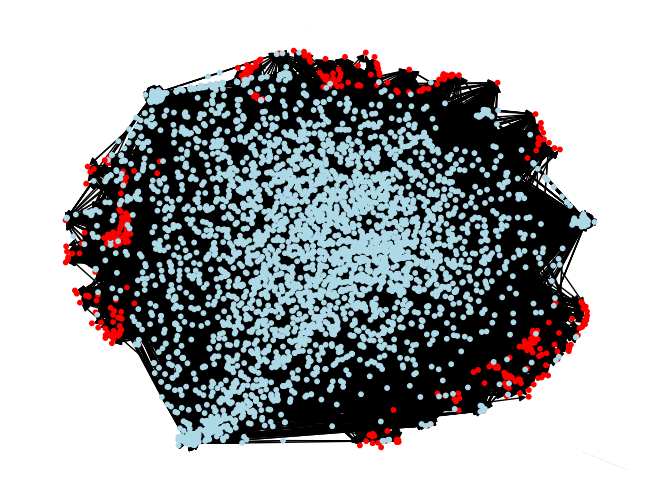

In [4]:
def node_color(x):
    return "lightblue" if type(x) == str else "red"


print("--- CODING SEQUENCES ---")

pagerank = nx.pagerank(G_coding)
sorted_pr = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 10 nodes by PageRank:")
for node, pr in sorted_pr[:10]:
    print(f"Node: {node}, PageRank: {pr}")

degree_centrality = nx.out_degree_centrality(G_coding)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by Out-Degree Centrality:")
for node, dc in sorted_degree[:10]:
    print(f"Node: {node}, Out-Degree Centrality: {dc}")

nx.draw(G_coding, pos=nx.forceatlas2_layout(G_coding), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G_coding.nodes()])

--- NON-CODING SEQUENCES ---
Top 10 nodes by PageRank:
Node: 4793, PageRank: 0.08619088307944313
Node: 3378, PageRank: 0.08197376340176783
Node: 407, PageRank: 0.06606307825285299
Node: 2558, PageRank: 0.03135147332159834
Node: 1545, PageRank: 0.02090430544453861
Node: 6445, PageRank: 0.011221303671365012
Node: 4014, PageRank: 0.010348503106505865
Node: 7612, PageRank: 0.010329536147393735
Node: 8707, PageRank: 0.009763513600654507
Node: 5234, PageRank: 0.0055785592500795
Top 10 nodes by Out-Degree Centrality:
Node: C, Out-Degree Centrality: 5.712121212121212
Node: G, Out-Degree Centrality: 5.5226234952262345
Node: T, Out-Degree Centrality: 4.909713574097136
Node: A, Out-Degree Centrality: 4.7339144873391446
Node: CCTCCC, Out-Degree Centrality: 0.2254047322540473
Node: TTTTTT, Out-Degree Centrality: 0.17393109173931093
Node: GCCTCC, Out-Degree Centrality: 0.1631382316313823
Node: CCCAGC, Out-Degree Centrality: 0.15960979659609797
Node: CTCCTG, Out-Degree Centrality: 0.1552511415525114


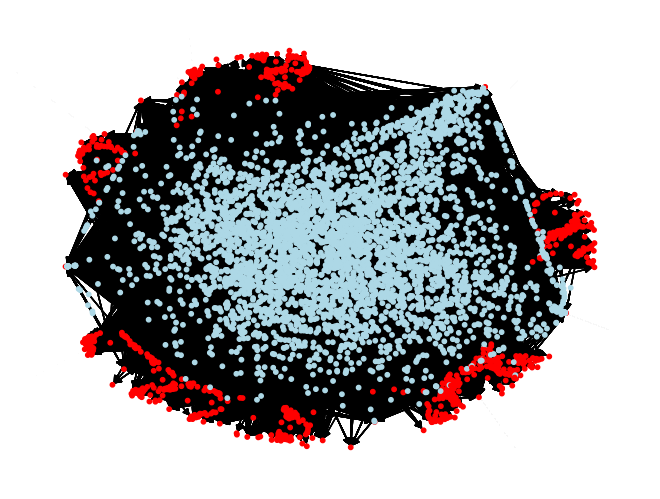

In [5]:
print("--- NON-CODING SEQUENCES ---")

pagerank = nx.pagerank(G_non_coding)
sorted_pr = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 10 nodes by PageRank:")
for node, pr in sorted_pr[:10]:
    print(f"Node: {node}, PageRank: {pr}")

degree_centrality = nx.out_degree_centrality(G_non_coding)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by Out-Degree Centrality:")
for node, dc in sorted_degree[:10]:
    print(f"Node: {node}, Out-Degree Centrality: {dc}")


nx.draw(G_non_coding, pos=nx.forceatlas2_layout(G_non_coding), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G_non_coding.nodes()])

In [6]:
# COMPARE TO ORIGINAL GRAPH
# use page rank to measure centrality
pagerank = nx.pagerank(OG)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by PageRank:")
for node, score in sorted_pagerank[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by PageRank:
3378: 0.05591438534474252
4793: 0.04776315882634009
407: 0.04058334611930585
2558: 0.02174499892379862
1545: 0.014473227554864115
7612: 0.009225784115039545
6445: 0.00832866187503917
8707: 0.008153740563806095
4014: 0.00770609877987153
9685: 0.005610925728333565


In [7]:
# COMPARE TO ORIGINAL GRAPH
# compare with degree centrality for important tokens
degree_centrality = nx.out_degree_centrality(OG)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by Degree Centrality:")
for node, score in sorted_degree[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by Degree Centrality:
<cls>: 7.103386809269162
C: 5.001782531194296
G: 4.875384864689678
T: 4.280343542375628
A: 4.147139847674607
CCTCCC: 0.19850915572840708
TTTTTT: 0.1523253929671042
GCCTCC: 0.15119105493437043
CCCAGC: 0.14584346135148274
GCCGCC: 0.14195430238210988


In [8]:
# export to cytoscape for visualization
# Didn't work for the large graph, so just keeping for documentation
for node in OG.nodes():
    OG.nodes[node]['id'] = node

cyto_data = nx.readwrite.json_graph.cytoscape_data(OG)
with open("data/cisplatin_pos_kg_cyto.json", "w") as f:
    json.dump(cyto_data, f)

# Using Knowledge Graph Patterns to Create Gene Sets

Note the strong centrality in multiple segments of the graph for features 3378, 407, and 4793, as well as typical base pairing hairpin motifs with high GC content in the outbound central nodes. 

By gathering data from the edges associated with each major feature, we can create gene sets based on GLM feature output. 

In [16]:
# Note that our non-coding graph lacks annotations by definition, so we will only create gene sets for coding regions
# 3378
edges = G_coding.in_edges(3378, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

os.makedirs("data/gene_sets", exist_ok=True)

with open("data/gene_sets/feature_3378_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_3378_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))

# 407
edges = G_coding.in_edges(407, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

with open("data/gene_sets/feature_407_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_407_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))


# 4793
edges = G_coding.in_edges(4793, data="annotations")

genes = []
motifs = []
for u, v, annotations in edges:
    for key, val in annotations.items():
        genes.append(val["gene_id"])
        motifs.append(u)

with open("data/gene_sets/feature_4793_genes.txt", "w") as f:
    f.write("\n".join(set(genes)))

with open("data/gene_sets/feature_4793_motifs.txt", "w") as f:
    f.write("\n".join(set(motifs)))
